[This was one of the more illuminating math videos I've come across](https://www.youtube.com/watch?v=EfZsEFhHcNM) and it did wonders for grounding my intuition on this topic. This notebook will mostly follow along, typing ideas from our other notebooks.

## Overview

Recall the intuition that we arrived at for eigenvectors when we went from following our basis vectors `i` and `j` in a linear transformation to finding the eigenvectors and watching the transformation from the perspective of the stretch/shrink on these vectors.

By orienting yourself to the problem via these vectors, we made it much easier to compute and represent linear transformations in a new basis. In a way, we can think of these new basis eigen vectors as "the essence" of these transformations. To answer the multitude of "where does *this* point go?" questions, we can articulate them relative to the eigen bases.

To hammer this notion home, I'll share the same video from the Eigenspaces notebook-- [it has a graphic so good that it merits reposting in my own resources](https://youtu.be/8F0gdO643Tc?t=291).

Using this general concept, we want to find a way to learn complex things about a matrix `A` by reformulating the problem into a simpler one based on properties of eigenvectors.

## Ingredients

Before we get into what Singular Value Decomposition *is*, let's first explore the Linear Algebra tricks that make it possible.


### Symmetric, Square Matrix

Say we have a matrix that's square and symmetric across the diag, like the following

```
a  d  e
d  b  f
e  f  c
```

Following along with the example in the video, we'll construct such a matrix, `s`

In [1]:
import numpy as np
import numpy.linalg as LA

s = np.array([[6, -2, -1],
              [-2, 6, -1],
              [-1, -1, 5]])

We'll then use `numpy` to find the eigenvalues and their corresponding eigenvectors

In [2]:
eigvals, eigvecs = LA.eig(s)
eigvals

array([3., 8., 6.])

The vectors have the interesting property of being both linearly independent and orthogonal (having dot product `=0`) to one another

In [3]:
import itertools

for vec_a, vec_b in itertools.combinations(eigvecs, 2):
    # is their dot product basically 0?
    # (accounts for float weirdness)
    print(np.isclose(0, np.dot(vec_a, vec_b)))

True
True
True


Furthermore, these eigenvectors are all **orthonormal**. So not only are they perpendicular, but they're also of unit length.

Thankfully, `numpy` handled this for us, but if it didn't we'd just have to scale each column in `eigvecs` by the magnitude of the column.

#### Diagonalizing It

After we've found our orthonormalized eigenvectors, we want to use them to diagonalize our matrix `s` into its constituent eigenbasis ([as discussed in this notebook](https://napsterinblue.github.io/notes/stats/lin_alg/eigenvectors_and_values/)).

Recall that the form here is `S = P D P^-1`, where `D` is our diagonal matrix and `P` is the mapping from our original space into the eigenbasis, in this case it's our matrix `eigvecs`.

In [4]:
eigvecs

array([[ 5.77350269e-01,  7.07106781e-01, -4.08248290e-01],
       [ 5.77350269e-01, -7.07106781e-01, -4.08248290e-01],
       [ 5.77350269e-01, -2.23967696e-17,  8.16496581e-01]])

Another interesting/useful property of working with the *isonormal eigenbasis* is that `P^-1` is equivalent to `P^T`

In [5]:
LA.inv(eigvecs)

array([[ 5.77350269e-01,  5.77350269e-01,  5.77350269e-01],
       [ 7.07106781e-01, -7.07106781e-01, -5.94118866e-19],
       [-4.08248290e-01, -4.08248290e-01,  8.16496581e-01]])

This makes calculation very convenient, as we don't need to deliberately calculate the inverse transformation from our eigenbasis to the original basis.

### Engineering Square Matricies

Nearly all of the data that we encounter can be represented via matricies and most of those matricies will likely be non-square. We can, however, use these rectangular matricies to *create* a square matrix by multiplying by the transpose, and vice-versa.

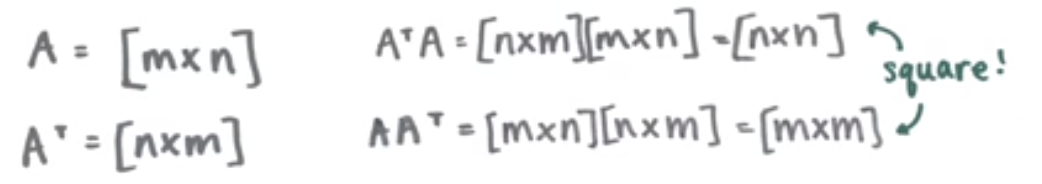

In [6]:
from IPython.display import Image

Image('images/nonsquare_to_square.PNG')

Take the following for example

In [7]:
A = np.array(([4, 11, 14],
              [8, 7, -2]))

In [8]:
AAt = A @ A.T
AAt

array([[333,  81],
       [ 81, 117]])

In [9]:
AtA = A.T @ A
AtA

array([[ 80, 100,  40],
       [100, 170, 140],
       [ 40, 140, 200]])

Furthermore, we can also see that these matricies are symmetric across the diag. This should be intuitive, but the following screengrab from the video spells out the calculation if it's not

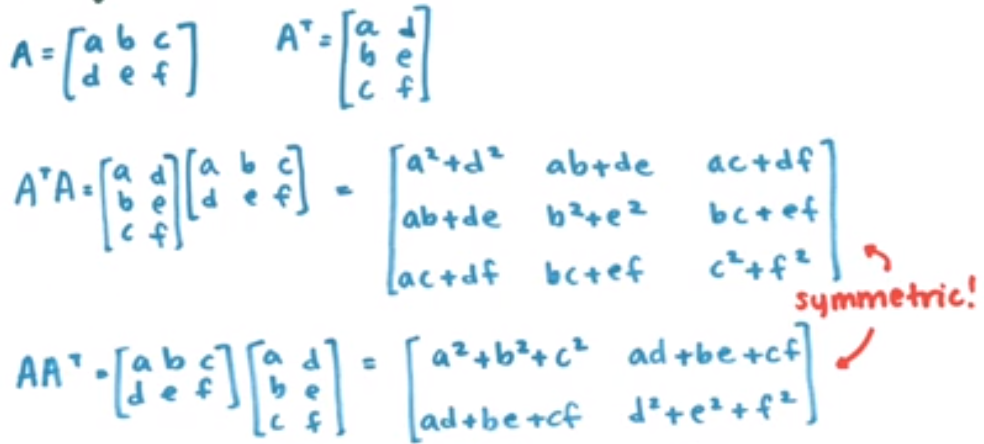

In [10]:
Image('images/symmetric_transposes.PNG')

### Diagonalizing the New Matricies

Moving along, we want to repeat the same orthonormal diagonalization as with our first square, symmetric matrix.

In doing this, we'll finally arrive at some notation that we'll need in performing SVD:

- `D` will be the diagonal matrix of eigenvalues for each `AtA` and `AAt`
- We'll call `V` the matrix that maps `AtA` to `D`
- We'll call `U` the matrix that maps `AAt` to `D`

If you want to follow along in the video, we're at about the 8 minute mark and will be doing these calculations in `numpy`

In [11]:
eigvals_v, V = LA.eig(AtA)
eigvals_v

array([ 3.60000000e+02, -3.18981901e-14,  9.00000000e+01])

**Note:** The video stresses many times that our matrix `D` of eigenvalues-- and the corresponding matrix of eigenvectors-- should be ordered in *descending order*. This doesn't come default when using `LA.eig()` (it will when we just use `LA.svd()`). Thus, we will manually reorder them, and construct a diagonal matrix from our 1D vector of eigen values.

In [12]:
eigvals_v = eigvals_v[[0, 2, 1]]
V = V[:, [0, 2, 1]]

In [13]:
D_v = np.diag(eigvals_v)
D_v

array([[ 3.60000000e+02,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.00000000e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -3.18981901e-14]])

Again, we can show equality between the inverse and transpose of `V`

In [14]:
np.isclose(LA.inv(V), V.T)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

Doing the same for `AAT`, we have

In [15]:
eigvals_u, U = LA.eig(AAt)
eigvals_u

array([360.,  90.])

In [16]:
D_u = np.diag(eigvals_u)
D_u

array([[360.,   0.],
       [  0.,  90.]])

You might have noted that the eigenvalues of both `D_u` and `D_v` are the exact same. This is no accident and is absolutely something we'll use in the next section.

## Putting it All Together

As it turns out, these orthonormal eigenvector matricies, `U` and `V` are instrumental in writing a simplified form of `A`. We say that our original matrix `A` can be written as

$A = U \Sigma V^T$

Where this `SIGMA` is the same as our matrix, `D`, but instead with the square root of each diagonal entry-- our eponymous *singular values*

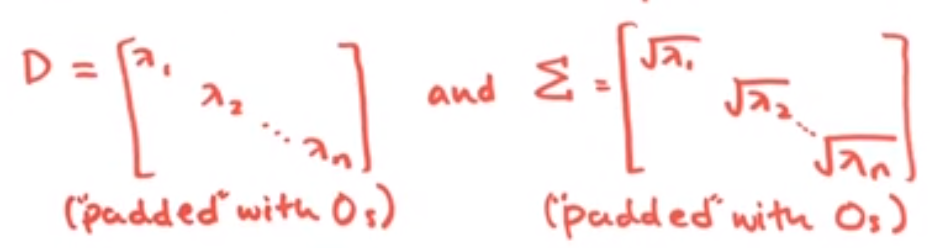

In [17]:
Image('images/singular_values.PNG')

And [Professor Strang](https://www.youtube.com/watch?v=mBcLRGuAFUk&t=1s) gives us a great gut check that this equation holds.

Substituting the `U SIGMA V^T` values in for `A`, we arrive at a clean diagonalization in terms of `SIGMA` and `V`. We'd get the same with `U` if we went swaped the two terms on the left.

Moreover, we get to enjoy the properties of the square, symmetric matricies that these two self-products provide.

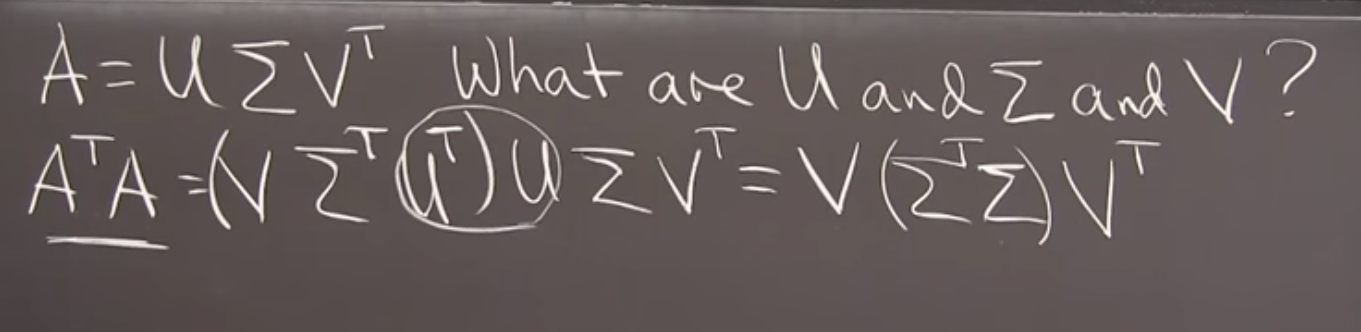

In [18]:
Image('images/confirming_v.PNG')

One thing to note is that depending on how our eigenvalue (`D`) shakes out, we might have some rank for `D` that's incompatible with `U` or `V^T` (due to duplicate or zero eigen values).

When this happens, we basically want to append a column of zeroes in `SIGMA` so the dimensions of the matrix multiplications work out.

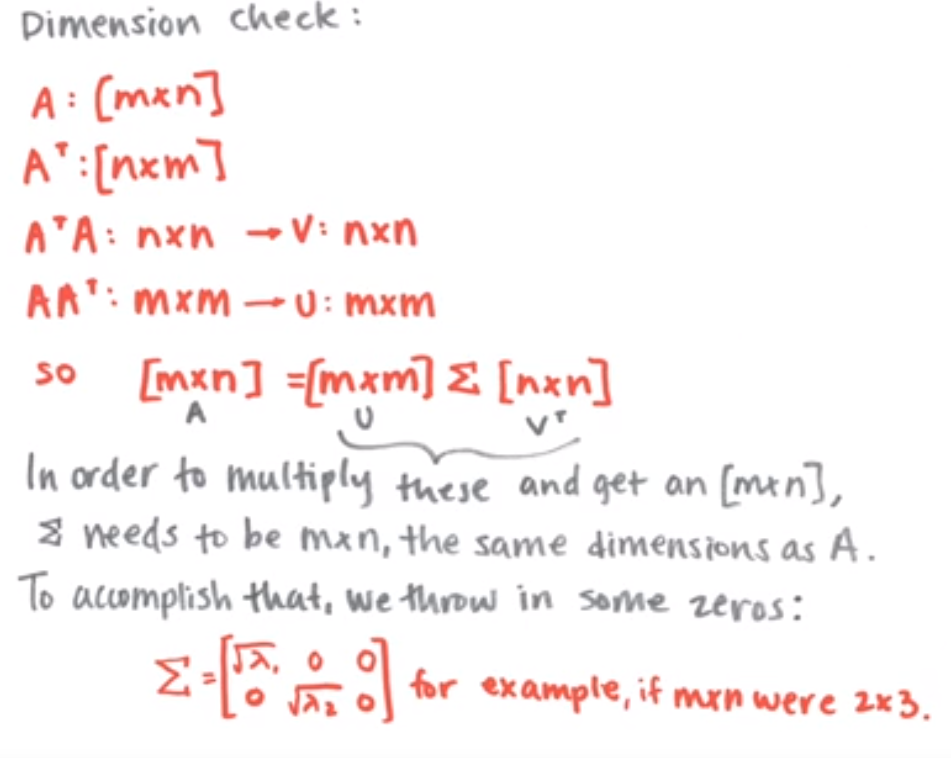

In [19]:
Image('images/svd_dimensions.PNG')

And so what we wind up with is basically a way to express our original matrix, `A` as a linear combination of the vectors in `U` and `V^T`.

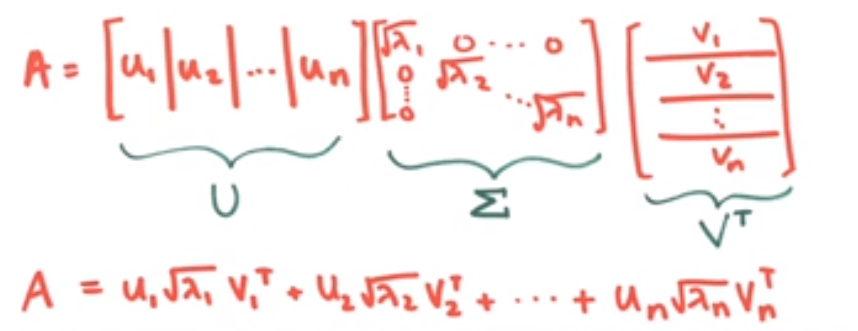

In [20]:
Image('images/svd_lin_comb.PNG')

## Conceptualizing

I've spent a couple days ruminating on this topic. Still don't feel like I've mastered SVD's but two facts that have helped ground my intuition for *why* this all works.

### Space to Space

[The writeup by the AMS](http://www.ams.org/publicoutreach/feature-column/fcarc-svd) explains SVDs as

> for any 2  2 matrix, we may find an orthogonal grid that is transformed into another orthogonal grid.

That that's some orthonormal eigen basis in our domain, and multiplying it by our matrix (we've been using `A`, they use `M`), moves us to *another* orthonormal eigen basis in the *co-domain*.

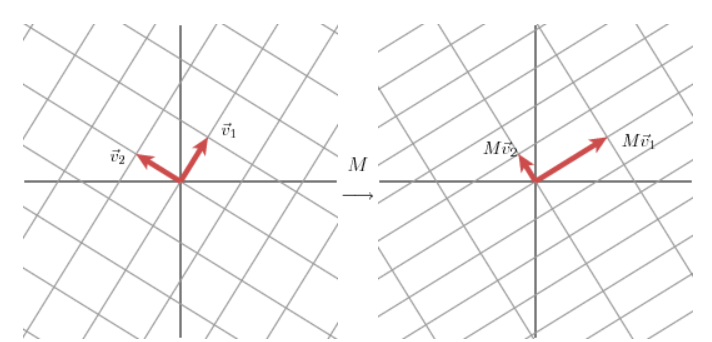

In [21]:
Image('images/orthog_to_orthog.PNG')

The transformation takes us to the basis formed by the unit vectors of `U`. The length of the lines `Mv1`, `Mv2` are scaled by our singular values as found above.

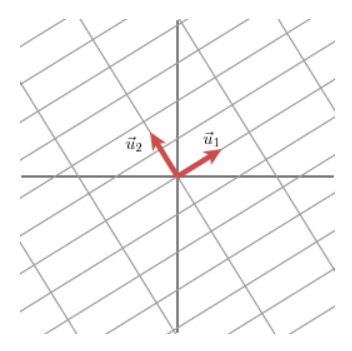

In [22]:
Image('images/u_in_codomain.PNG')

All at once, this happens as the following (per [Strang's iconic paper](http://www.souravsengupta.com/cds2016/lectures/Strang_Paper1.pdf))

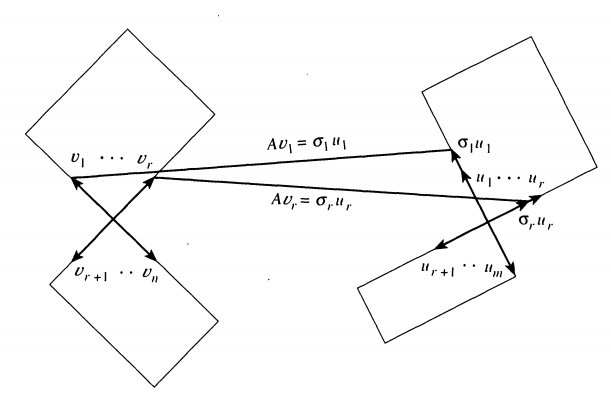

In [23]:
Image('images/orthog_to_orthog_one_step.PNG')

### Rotate, Scale, Rotate

Another way to think about this transformation-- indeed all transformations-- is that any transformation can be described as:

- A rotation (to orient to our row space, `V`)
- A scaling stretching by `sigma` values
- Another rotation (relative to our column space, `U`)

Visually, the [wikipedia article on the topic](https://en.wikipedia.org/wiki/Singular_value_decomposition) explains the `U` and `V^T` terms as rotations and `SIGMA` as the term that scales our space by a factor of our *singular values*.